In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import torch
import umap
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.decomposition import PCA

Using backend: pytorch


In [3]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='../../data/dataset_dgl')
graph = dataset[0][0]

In [4]:
output_emb_file = '../../models/graphsage_link_pred/full_graphsage_linkpred_15_h.npy'

In [5]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 50)

## L2 Distance

In [6]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [7]:
index.train(embeddings)
index.add(embeddings)

In [8]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7fa910575180> >

In [9]:
index.ntotal

169343

### Check if the closest embedding is a neighbor

In [10]:
distances, indices = index.search(embeddings, 2)

In [11]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(27824)

In [12]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [13]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [14]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [15]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

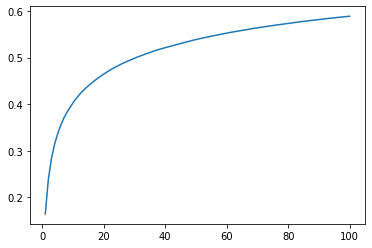

In [16]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [17]:
percentages

tensor([0.1643, 0.2389, 0.2830, 0.3133, 0.3360, 0.3543, 0.3696, 0.3819, 0.3926,
        0.4027, 0.4117, 0.4197, 0.4269, 0.4335, 0.4393, 0.4448, 0.4503, 0.4552,
        0.4600, 0.4644, 0.4688, 0.4728, 0.4769, 0.4802, 0.4836, 0.4870, 0.4900,
        0.4930, 0.4957, 0.4985, 0.5013, 0.5038, 0.5061, 0.5086, 0.5109, 0.5133,
        0.5155, 0.5176, 0.5194, 0.5214, 0.5231, 0.5249, 0.5267, 0.5285, 0.5302,
        0.5319, 0.5337, 0.5354, 0.5372, 0.5387, 0.5403, 0.5417, 0.5432, 0.5445,
        0.5459, 0.5473, 0.5485, 0.5499, 0.5513, 0.5525, 0.5538, 0.5550, 0.5561,
        0.5572, 0.5584, 0.5596, 0.5606, 0.5618, 0.5629, 0.5639, 0.5649, 0.5659,
        0.5670, 0.5679, 0.5688, 0.5698, 0.5706, 0.5715, 0.5725, 0.5734, 0.5742,
        0.5753, 0.5761, 0.5769, 0.5778, 0.5785, 0.5794, 0.5802, 0.5808, 0.5816,
        0.5824, 0.5832, 0.5840, 0.5847, 0.5854, 0.5862, 0.5868, 0.5875, 0.5881,
        0.5888])

In [18]:
percentages.max()

tensor(0.5888)

### Percentage of same class neighbors by neighborhood size

In [19]:
y = dataset[0][1][:, 0]

In [20]:
label_dict = {idx: val for idx, val in enumerate(y.numpy())}

In [21]:
label_transform = np.vectorize(label_dict.get)

In [22]:
ind_labels = label_transform(indices)

In [23]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [24]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [25]:
perc_same_class = n_same_class / n_total

In [26]:
perc_same_class

array([0.63489486, 0.61808283, 0.60600871, 0.59636802, 0.58879198,
       0.58236538, 0.57683181, 0.57209406, 0.56780223, 0.56412843,
       0.56060669, 0.55745144, 0.55462218, 0.55189678, 0.54936864,
       0.54711222, 0.54506951, 0.54307005, 0.54121734, 0.5394941 ,
       0.53785765, 0.53626153, 0.5347757 , 0.53338048, 0.5319601 ,
       0.53067239, 0.52943041, 0.52822294, 0.52709386, 0.52602627,
       0.52494089, 0.52390101, 0.52290018, 0.52192157, 0.52097476,
       0.52005594, 0.51917354, 0.51829454, 0.51745184, 0.51658454,
       0.51583026, 0.51500617, 0.51426395, 0.51353412, 0.51277663,
       0.51209226, 0.5114208 , 0.51072269, 0.51003331, 0.50934364,
       0.50869606, 0.50807294, 0.50743712, 0.50685416, 0.50623678,
       0.50566781, 0.5050985 , 0.50453049, 0.50397553, 0.50344636,
       0.50289291, 0.50233969, 0.50183356, 0.50133678, 0.50089164,
       0.50040737, 0.4999335 , 0.49945117, 0.49898153, 0.49853029,
       0.49807105, 0.49762227, 0.49718271, 0.49674657, 0.49632

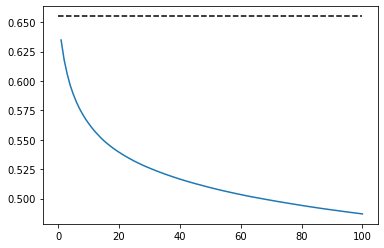

In [27]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Cossine Distance

In [28]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [29]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [30]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [31]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fa806706cf0> >

In [32]:
index_cos.ntotal

169343

### Check if the closest embedding is a neighbor

In [33]:
distances, indices = index_cos.search(emb_norm, 2)

In [34]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(28823)

In [35]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [36]:
(sum(emb_norm[0] * emb_norm[411]) + 1) / 2

0.7985187687590951

In [37]:
max_k = 100
distances, indices = index_cos.search(emb_norm, max_k + 1)

In [38]:
indices

array([[     0, 134013,  36054, ..., 125495,  86553, 136696],
       [     1, 154949, 141692, ..., 164135, 127644, 153434],
       [     2, 122406,  65576, ..., 166975,    860, 103194],
       ...,
       [169340,  18094,   2618, ...,  45789, 169147,  40678],
       [169341, 103121,  91330, ...,  34900,  20500,   3521],
       [169342, 127946, 110563, ...,  89570,  62031,  84553]])

In [39]:
sum(emb_norm[0] * emb_norm[411])

0.5970375375181902

In [40]:
distances

array([[0.99999994, 0.9727427 , 0.966068  , ..., 0.8624083 , 0.8622685 ,
        0.86183983],
       [0.9999998 , 0.9912001 , 0.97433645, ..., 0.89887375, 0.89879185,
        0.89850396],
       [1.0000001 , 0.98006624, 0.9780302 , ..., 0.9177198 , 0.9173742 ,
        0.9171551 ],
       ...,
       [1.0000001 , 0.95797503, 0.9572784 , ..., 0.8534898 , 0.85338354,
        0.85294586],
       [0.99999994, 0.9772386 , 0.96934617, ..., 0.90404767, 0.9038877 ,
        0.903645  ],
       [1.0000001 , 0.95405185, 0.9454266 , ..., 0.9031722 , 0.90249264,
        0.90159404]], dtype=float32)

In [41]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [42]:
has_neighbor

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

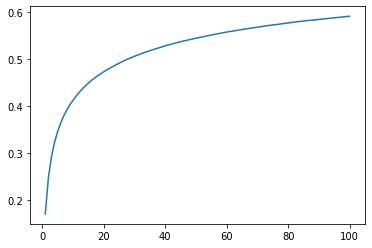

In [43]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [44]:
percentages

tensor([0.1702, 0.2468, 0.2916, 0.3221, 0.3450, 0.3633, 0.3785, 0.3910, 0.4024,
        0.4115, 0.4204, 0.4283, 0.4357, 0.4422, 0.4482, 0.4539, 0.4587, 0.4637,
        0.4680, 0.4723, 0.4763, 0.4801, 0.4836, 0.4872, 0.4905, 0.4938, 0.4970,
        0.4997, 0.5025, 0.5053, 0.5078, 0.5102, 0.5126, 0.5148, 0.5170, 0.5193,
        0.5212, 0.5233, 0.5253, 0.5275, 0.5293, 0.5311, 0.5328, 0.5346, 0.5362,
        0.5377, 0.5392, 0.5407, 0.5421, 0.5436, 0.5450, 0.5463, 0.5477, 0.5491,
        0.5505, 0.5516, 0.5529, 0.5542, 0.5555, 0.5568, 0.5578, 0.5588, 0.5599,
        0.5610, 0.5621, 0.5632, 0.5642, 0.5651, 0.5662, 0.5671, 0.5681, 0.5690,
        0.5701, 0.5710, 0.5718, 0.5726, 0.5735, 0.5744, 0.5753, 0.5761, 0.5770,
        0.5779, 0.5787, 0.5794, 0.5802, 0.5809, 0.5815, 0.5821, 0.5828, 0.5836,
        0.5842, 0.5850, 0.5856, 0.5863, 0.5870, 0.5877, 0.5884, 0.5890, 0.5897,
        0.5904])

### Percentage of same class neighbors by neighborhood size

In [45]:
ind_labels = label_transform(indices)

In [46]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [47]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [48]:
perc_same_class = n_same_class / n_total

In [49]:
perc_same_class

array([0.6373396 , 0.62156393, 0.60964827, 0.60055036, 0.59304134,
       0.5867106 , 0.58124128, 0.57647939, 0.57203887, 0.56832937,
       0.56487935, 0.5618572 , 0.55905652, 0.55655976, 0.55402743,
       0.55168504, 0.54950221, 0.54741462, 0.54554521, 0.54370892,
       0.54201124, 0.5404338 , 0.53897325, 0.53759554, 0.53618443,
       0.53492843, 0.53366048, 0.53243523, 0.53127248, 0.53010694,
       0.52901412, 0.52803519, 0.52709607, 0.52608854, 0.5251541 ,
       0.52426896, 0.52340005, 0.52250851, 0.52166737, 0.52086298,
       0.52009236, 0.51933045, 0.5185897 , 0.5178245 , 0.51711772,
       0.51640933, 0.51570783, 0.51503138, 0.51440061, 0.5137698 ,
       0.51313236, 0.51249285, 0.51187124, 0.51128665, 0.51069862,
       0.51013497, 0.50955576, 0.50897291, 0.50843044, 0.50786372,
       0.50734609, 0.50684257, 0.50631558, 0.50583459, 0.50535032,
       0.50485173, 0.50433215, 0.50386242, 0.50337601, 0.50291311,
       0.50244562, 0.50200013, 0.50157017, 0.50113794, 0.50074

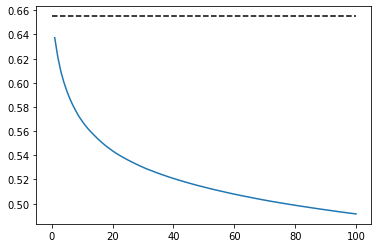

In [50]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Inner Product

In [51]:
index_ip = faiss.IndexFlatIP(embeddings.shape[1])

In [52]:
index_ip.train(embeddings)
index_ip.add(embeddings)

In [53]:
index_ip

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7fa8045a5fc0> >

In [54]:
index_ip.ntotal

169343

### Check if the closest embedding is a neighbor

In [55]:
distances, indices = index_ip.search(embeddings, 2)

In [56]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(2456)

In [57]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [58]:
(sum(embeddings[0] * embeddings[411]) + 1) / 2

17.269814810715616

In [59]:
max_k = 100
distances, indices = index_ip.search(embeddings, max_k + 1)

In [60]:
indices

array([[131524,  89840, 130323, ...,  26894, 151522, 164531],
       [  1705,  55681,  58920, ..., 137784, 163581, 149621],
       [ 22018,  84941,  41273, ..., 137908, 155206,  29309],
       ...,
       [ 83581,  80239,  93263, ...,  65637,  31917,  26500],
       [ 78121,  99734,  70406, ...,   9334,  30078,  57255],
       [ 57775, 117521,  54485, ..., 116298, 123007,  52166]])

In [61]:
sum(embeddings[0] * embeddings[411])

33.53962962143123

In [62]:
distances

array([[ 41.088184,  40.809757,  40.66342 , ...,  33.913177,  33.89481 ,
         33.87687 ],
       [224.33978 , 218.89192 , 216.82544 , ..., 191.63055 , 191.53117 ,
        191.45216 ],
       [100.04504 ,  98.11096 ,  96.16556 , ...,  83.866684,  83.84443 ,
         83.7476  ],
       ...,
       [ 71.946556,  71.47536 ,  70.995346, ...,  60.470486,  60.461666,
         60.458263],
       [ 76.49895 ,  74.33075 ,  73.77816 , ...,  60.648487,  60.573765,
         60.554043],
       [108.49523 , 108.003334, 105.198906, ...,  96.225525,  96.21449 ,
         96.18513 ]], dtype=float32)

In [63]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [64]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

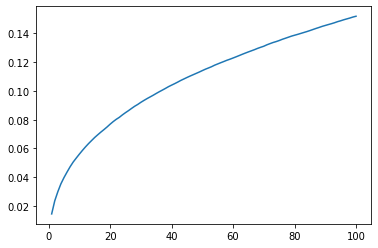

In [65]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [66]:
percentages

tensor([0.0145, 0.0236, 0.0299, 0.0354, 0.0397, 0.0436, 0.0473, 0.0506, 0.0534,
        0.0561, 0.0587, 0.0611, 0.0634, 0.0656, 0.0677, 0.0696, 0.0714, 0.0731,
        0.0749, 0.0769, 0.0787, 0.0803, 0.0817, 0.0834, 0.0849, 0.0863, 0.0879,
        0.0894, 0.0906, 0.0921, 0.0934, 0.0947, 0.0958, 0.0970, 0.0983, 0.0995,
        0.1006, 0.1018, 0.1030, 0.1040, 0.1051, 0.1062, 0.1073, 0.1083, 0.1094,
        0.1103, 0.1113, 0.1122, 0.1132, 0.1142, 0.1151, 0.1160, 0.1169, 0.1179,
        0.1188, 0.1196, 0.1205, 0.1214, 0.1221, 0.1229, 0.1238, 0.1246, 0.1255,
        0.1264, 0.1272, 0.1280, 0.1287, 0.1296, 0.1304, 0.1311, 0.1321, 0.1329,
        0.1337, 0.1343, 0.1351, 0.1359, 0.1366, 0.1374, 0.1381, 0.1387, 0.1393,
        0.1400, 0.1406, 0.1413, 0.1420, 0.1427, 0.1435, 0.1442, 0.1449, 0.1456,
        0.1462, 0.1468, 0.1474, 0.1482, 0.1488, 0.1495, 0.1501, 0.1507, 0.1514,
        0.1520])

### Percentage of same class neighbors by neighborhood size

In [67]:
ind_labels = label_transform(indices)

In [68]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [69]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [70]:
perc_same_class = n_same_class / n_total

In [71]:
perc_same_class

array([0.29153848, 0.28280472, 0.27841324, 0.27552364, 0.27345683,
       0.27184767, 0.27057426, 0.2694044 , 0.26839806, 0.26765086,
       0.2668119 , 0.26605666, 0.26536765, 0.26466698, 0.26410225,
       0.26350181, 0.26304948, 0.26253094, 0.26191066, 0.2614333 ,
       0.26094995, 0.2604123 , 0.2598965 , 0.25938603, 0.25888853,
       0.2583598 , 0.25787548, 0.25743419, 0.25701743, 0.25665425,
       0.25621029, 0.25580811, 0.25533582, 0.25487828, 0.2544609 ,
       0.25409294, 0.25369875, 0.25330138, 0.25293075, 0.25257052,
       0.25222845, 0.25185303, 0.25151004, 0.25114695, 0.25078581,
       0.25042472, 0.25008654, 0.24975235, 0.24942976, 0.24909964,
       0.24878675, 0.24847022, 0.24814268, 0.24783242, 0.24751647,
       0.24719599, 0.2469025 , 0.2465947 , 0.24627861, 0.24596007,
       0.2456483 , 0.24535772, 0.24504469, 0.2447575 , 0.24451557,
       0.2442476 , 0.24397071, 0.24369527, 0.24341045, 0.24312271,
       0.24284499, 0.24260828, 0.24235549, 0.24208256, 0.24183

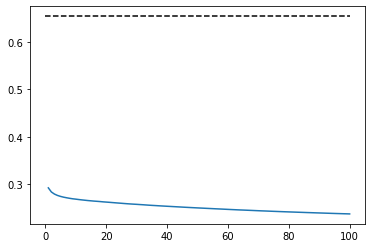

In [72]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Scatter Plot PCA 2dim

In [73]:
pca = PCA(n_components=2)

In [74]:
pca.fit(embeddings)

PCA(n_components=2)

In [75]:
emb_2d = pca.transform(embeddings)

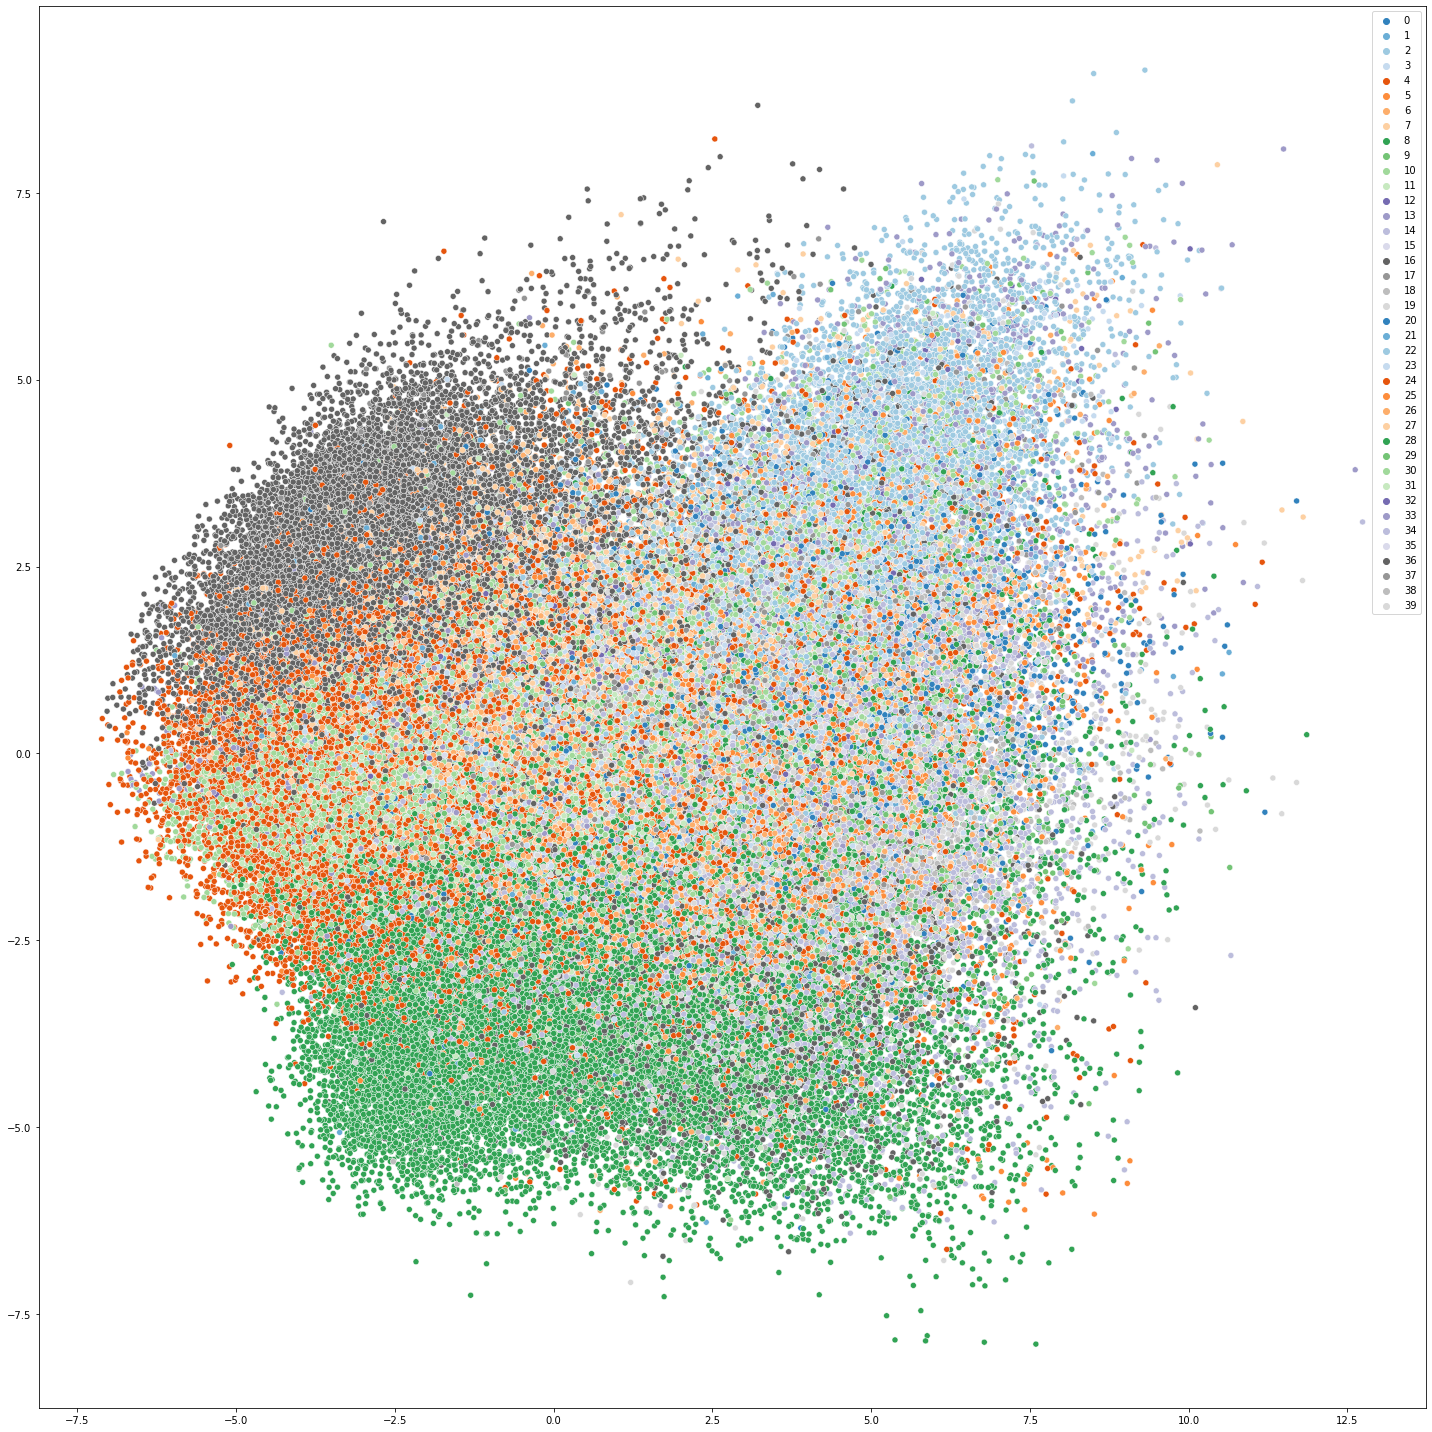

In [76]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d

In [77]:
emb_umap_2d = umap.UMAP(n_components=2).fit_transform(embeddings)

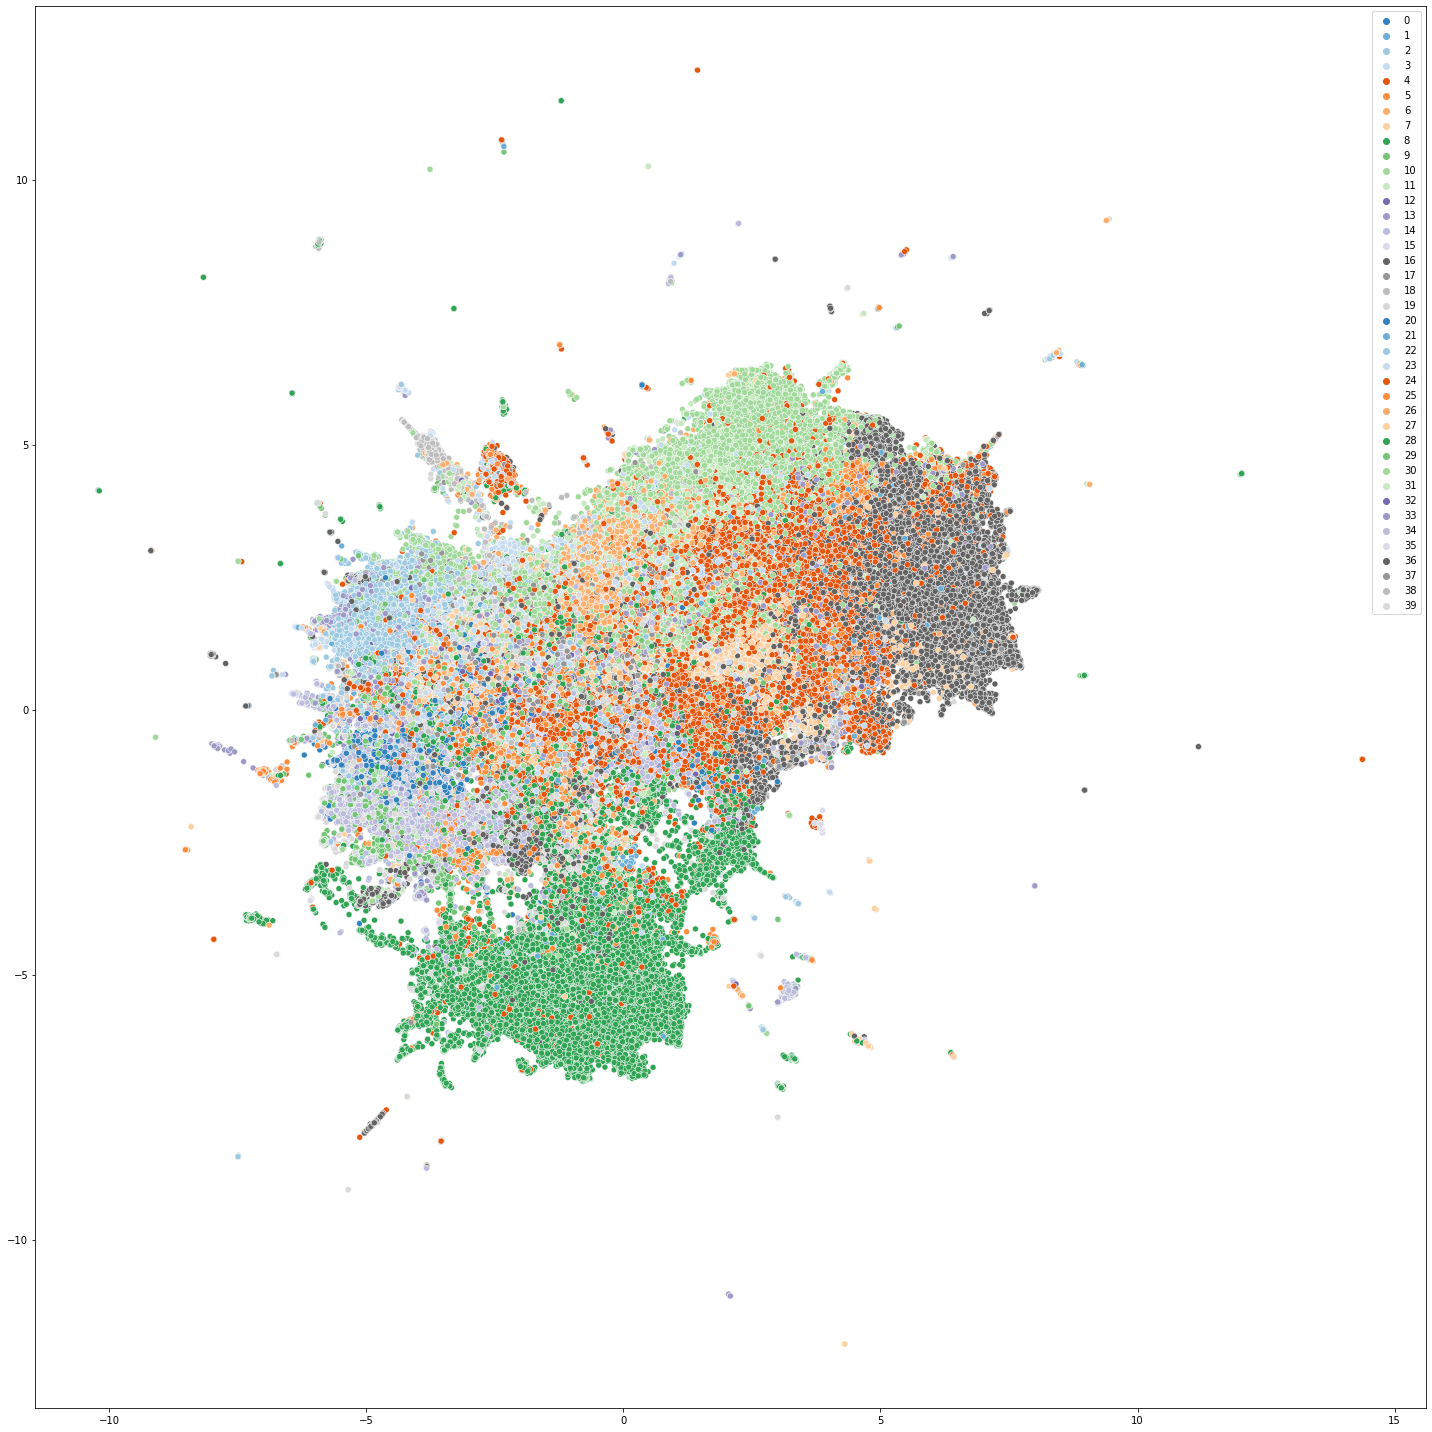

In [78]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d[:,0], y=emb_umap_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d - Normalized embeddings

In [79]:
emb_umap_2d_norm = umap.UMAP(n_components=2).fit_transform(emb_norm)

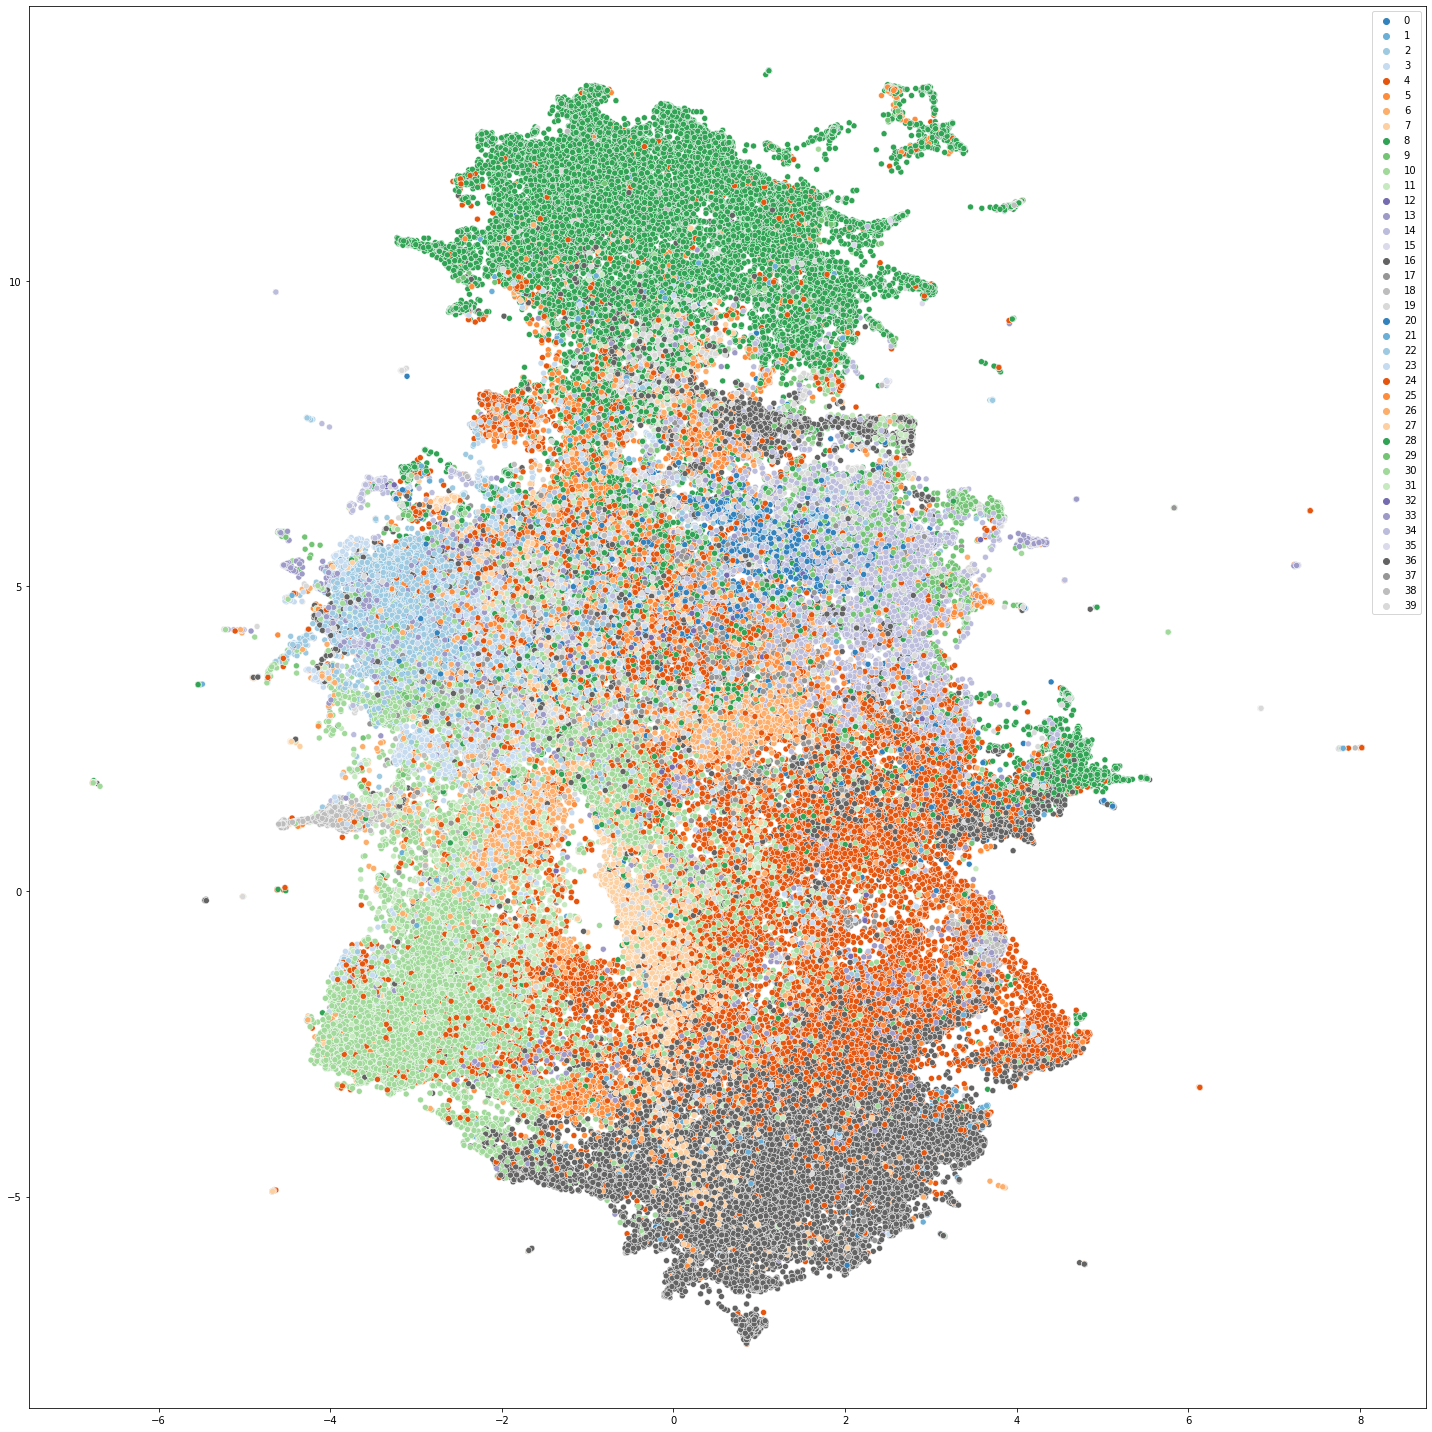

In [80]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d_norm[:,0], y=emb_umap_2d_norm[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()